In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
transactions_df = pd.read_parquet("transaction_fraud_data.parquet")
exchange_df = pd.read_parquet("historical_currency_exchange.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'transaction_fraud_data.parquet'

### Гипотеза 1: Можно создать динамическую систему риск-скоринга, которая будет запрашивать дополнительную аутентификацию (2FA) только для подозрительных, но не очевидно мошеннических операций. Это снизит количество ложных срабатываний и улучшит пользовательский опыт.

/var/folders/g0/db_6133s4c72c83lmc3808m40000gn/T/ipykernel_98897/727710823.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_category.index, y=fraud_rate_by_category.values, palette="viridis")


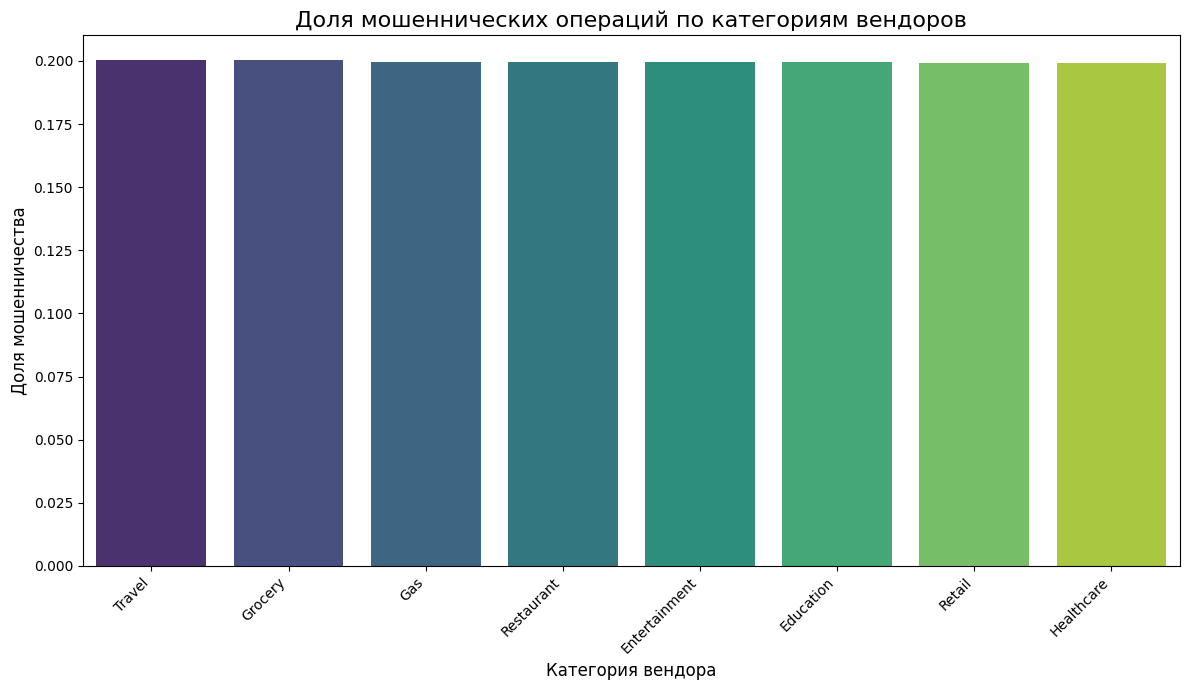

In [3]:
fraud_rate_by_category = (
    transactions_df.groupby("vendor_category")["is_fraud"]
    .mean()
    .sort_values(ascending=False)
)

# Визуализация
plt.figure(figsize=(12, 7))
sns.barplot(x=fraud_rate_by_category.index, y=fraud_rate_by_category.values, palette="viridis")
plt.title('Доля мошеннических операций по категориям вендоров', fontsize=16)
plt.xlabel('Категория вендора', fontsize=12)
plt.ylabel('Доля мошенничества', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Вывод, который мы ожидаем увидеть:
# Если график покажет, что у категорий "Путешествия" или "Развлечения"
# доля мошенничества значительно выше, чем у "Продукты" или "Здоровье",
# гипотеза подтверждается. Транзакции в этих категориях должны получать более высокий балл риска.

### Гипотеза 2: Можно выявлять "скомпрометированных" вендоров и временно блокировать или ограничивать операции с ними, информируя об этом клиентов.

In [6]:
vendor_risk_profile = transactions_df.groupby('vendor').agg(
    total_transactions=('transaction_id', 'count'),
    fraud_transactions=('is_fraud', lambda x: x.sum()),
    total_fraud_amount=('amount', lambda x: transactions_df.loc[x.index[transactions_df.loc[x.index, 'is_fraud'] == True], 'amount'].sum())
).reset_index()

# Рассчитаем долю мошенничества
vendor_risk_profile['fraud_rate'] = vendor_risk_profile['fraud_transactions'] / vendor_risk_profile['total_transactions']

# Ищем вендоров с высокой долей мошенничества и значительным числом транзакций
risky_vendors = vendor_risk_profile[
    (vendor_risk_profile["fraud_rate"] > 0.1)  # Например, доля мошенничества > 10%
    & (vendor_risk_profile["total_transactions"] > 10)  # И было хотя бы 10 транзакций
].sort_values(by="fraud_rate", ascending=False)

risky_vendors

# Вывод, который мы ожидаем увидеть:
# Если в таблице `risky_vendors` появятся конкретные названия вендоров с
# высоким `fraud_rate` и значительной суммой потерь, это подтверждает гипотезу.
# Бизнес может принять решение о расследовании в отношении этих вендоров.


,vendor,total_transactions,fraud_transactions,total_fraud_amount,fraud_rate
92,United Airlines,39226,8005,2.991581e+09,0.204074
90,Uber,46700,9497,2.071867e+08,0.203362
68,Publix,67095,13639,9.131798e+08,0.203279
81,StubHub,62696,12710,1.414635e+09,0.202724
45,JetBlue,38934,7883,2.894411e+09,0.202471
...,...,...,...,...,...
4,Amazon,66550,13139,2.910583e+09,0.197431
43,IKEA,58302,11493,1.264002e+09,0.197129
23,Delta,38935,7666,2.952690e+09,0.196892
34,HBO Max,44219,8691,9.879504e+07,0.196544


### Гипотеза 3: Признаки из структуры ⁠last_hour_activity являются одними из самых сильных предикторов мошенничества.

In [ ]:
last_hour_features = ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']
for feature in last_hour_features:
    # Пример доступа к полю структуры. Синтаксис может отличаться.
    transactions_df[f'lh_{feature}'] = transactions_df['last_hour_activity'].apply(lambda x: x.get(feature) if isinstance(x, dict) else None)

# Сравним распределения для `lh_num_transactions`
plt.figure(figsize=(12, 6))
sns.histplot(data=transactions_df, x='lh_num_transactions', hue='is_fraud', kde=True, bins=50, multiple="stack")
plt.title('Распределение количества транзакций за последний час', fontsize=16)
plt.xlabel('Кол-во транзакций за час', fontsize=12)
plt.xlim(0, 40) # Ограничим для наглядности
plt.show()